In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
from itertools import islice 
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from skimage.segmentation import find_boundaries
from csbdeep.io import save_tiff_imagej_compatible
from stardist import dist_to_coord, non_maximum_suppression, polygons_to_label
from stardist import random_label_cmap, draw_polygons, sample_points
from stardist import Config, StarDist

np.random.seed(6)
lbl_cmap = random_label_cmap()

/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [2]:
basedir = '/data/u934/service_imagerie/v_kapoor/StarDistData/TimeData/'
basedirResultsWithoutShape = '/data/u934/service_imagerie/v_kapoor/StarDistData/JuliaResultsData/WithoutShapeCompletion/'
ModelNameWithoutShape = 'PreAnnotatedStardistWithoutShapeCompletion'
BaseDirModels = 'models'

In [16]:
Path = os.path.join(basedir, '*.tif')
X = []
Names = []

filesRaw = glob.glob(Path)
maxtime = 0
for fname in filesRaw:
     x = imread(fname)
     X.append(x)
     Names.append(fname)
     if X[0].shape[0] > maxtime:
      maxtime =  X[0].shape[0]  
X.sort
Names.sort
SegmentedLabelsWithoutShape = [];


axes = 'TXY'
print('Total number of images to be segmented = ', len(X))
print('Image size = ', X[0].shape)
print('Time dim = ', maxtime )
timerange = maxtime 
count = min(0, len(X))

Total number of images to be segmented =  2
Image size =  (3, 512, 640)
Time dim =  3


In [4]:
model_no_sc = StarDist(None, name = ModelNameWithoutShape, basedir = BaseDirModels )

Loading network weights from 'weights_best.h5'.


In [5]:
img = normalize(X[0],1,99.8)
prob = np.array(img)
labels = np.array(img)


dist = np.zeros((img.shape[0], img.shape[1] ,img.shape[2], 32))
coord = np.zeros((img.shape[0], img.shape[1] ,img.shape[2],2, 32))
print(dist.shape, labels.shape)

maxpoints = 0;
secdim = 0;
for i in range(timerange):
      smallimg = img[i,:,:]
      smallprob, smalldist = model_no_sc.predict(smallimg)
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=0.2)
      secdim = smallpoints.shape[1]
      if smallpoints.shape[0] > maxpoints: 
          maxpoints = smallpoints.shape[0]
            
            
points = np.zeros((img.shape[0],maxpoints ,2), dtype = 'i')           
newsmallpoints = np.zeros((maxpoints, secdim), dtype = 'i')
for i in range(timerange):
   print('Time point = ' , i)
   smallimg = img[i,:,:]
   smallprob, smalldist = model_no_sc.predict(smallimg)
   smallcoord = dist_to_coord(smalldist)
   smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=0.2)

   newsmallpoints[:smallpoints.shape[0], :smallpoints.shape[1]] = smallpoints;
   
   smalllabels = polygons_to_label(smallcoord,smallprob,newsmallpoints)
  
   prob[i,:,:] = smallprob[:,:] 
   labels[i,:,:] = smalllabels[:,:]
   dist[i,:,:,:] = smalldist[:,:,:]
   coord[i,:,:,:,:] = smallcoord[:,:,:,:]
    
            
    
   points[i,:,:] = newsmallpoints[:,:] 
  
   print(smalldist.shape, prob.shape, dist.shape, smallcoord.shape, newsmallpoints.shape, points.shape)

(3, 512, 640, 32) (3, 512, 640)


/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]


Time point =  0
(512, 640, 32) (3, 512, 640) (3, 512, 640, 32) (512, 640, 2, 32) (142, 2) (3, 142, 2)
Time point =  1
(512, 640, 32) (3, 512, 640) (3, 512, 640, 32) (512, 640, 2, 32) (142, 2) (3, 142, 2)
Time point =  2
(512, 640, 32) (3, 512, 640) (3, 512, 640, 32) (512, 640, 2, 32) (142, 2) (3, 142, 2)


Time point =  2


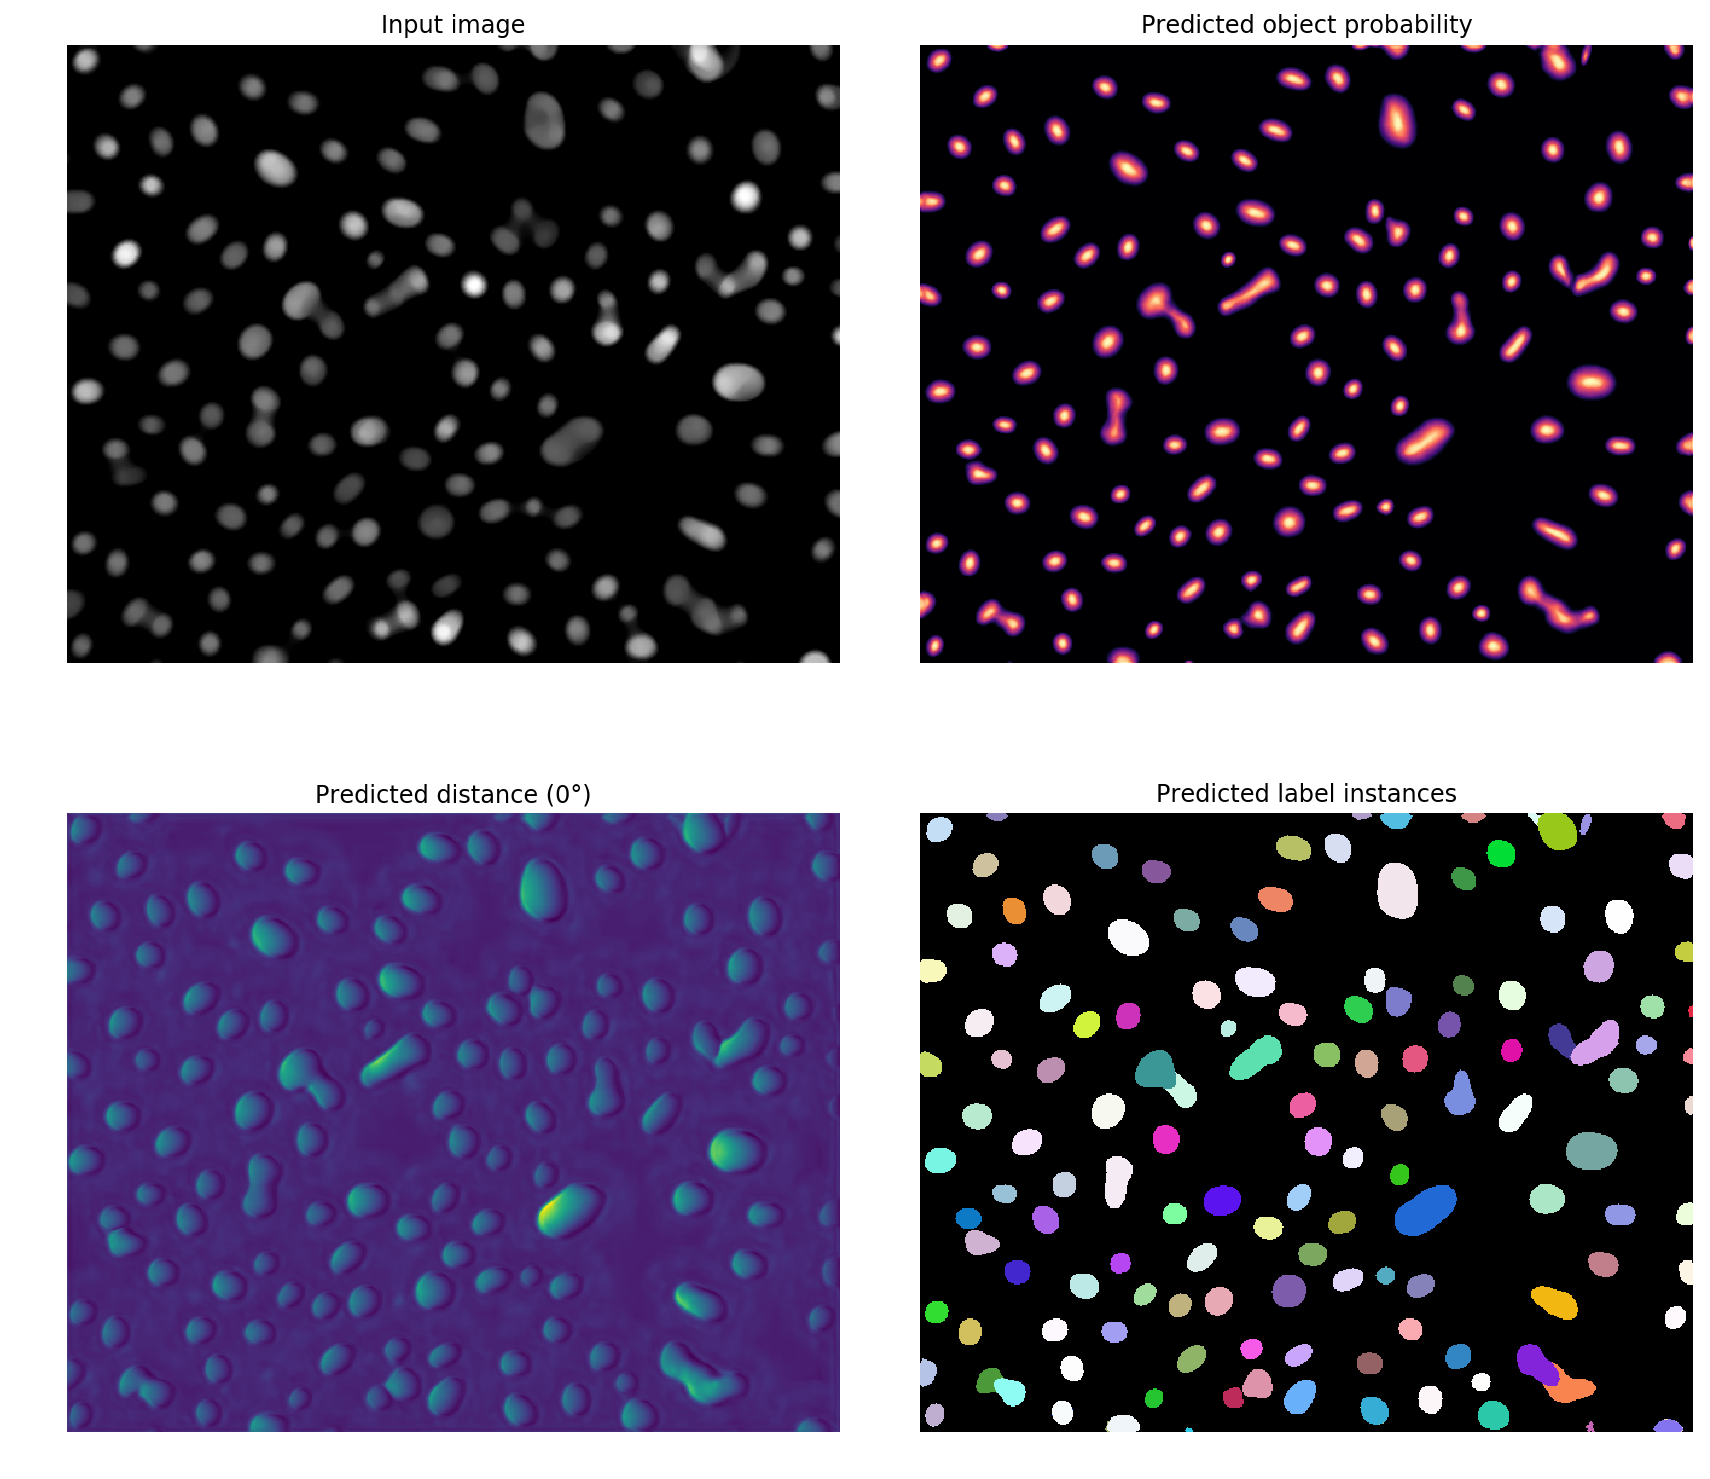

In [6]:
newsmalllabels = np.array(smalllabels)
newsmallprob = np.array(smallprob)
newsmalldist = np.array(smalldist)
newsmallimg = np.array(smallimg)
newsmallcoord = np.array(smallcoord)
i = timerange - 1
print('Time point = ' , i)
newsmalldist  = dist[i,:,:,:]
newsmalllabels = labels[i,:,:] 
newsmallprob = prob[i,:,:] 
newsmallimg = img[i,:,:]
newsmallcoord = coord[i,:,:,:,:]
fig, ax = plt.subplots(2,2, figsize=(12,12))
for a,d,cm,s in zip(ax.flat, [newsmallimg,newsmallprob,newsmalldist[...,0],newsmalllabels], ['gray','magma','viridis',lbl_cmap],
                    ['Input image','Predicted object probability','Predicted distance (0°)','Predicted label instances']):
          a.imshow(d,cmap=cm)
          a.set_title(s)
          a.axis('off')
          plt.tight_layout()
None;

Time point =  0
Time point =  1
Time point =  2


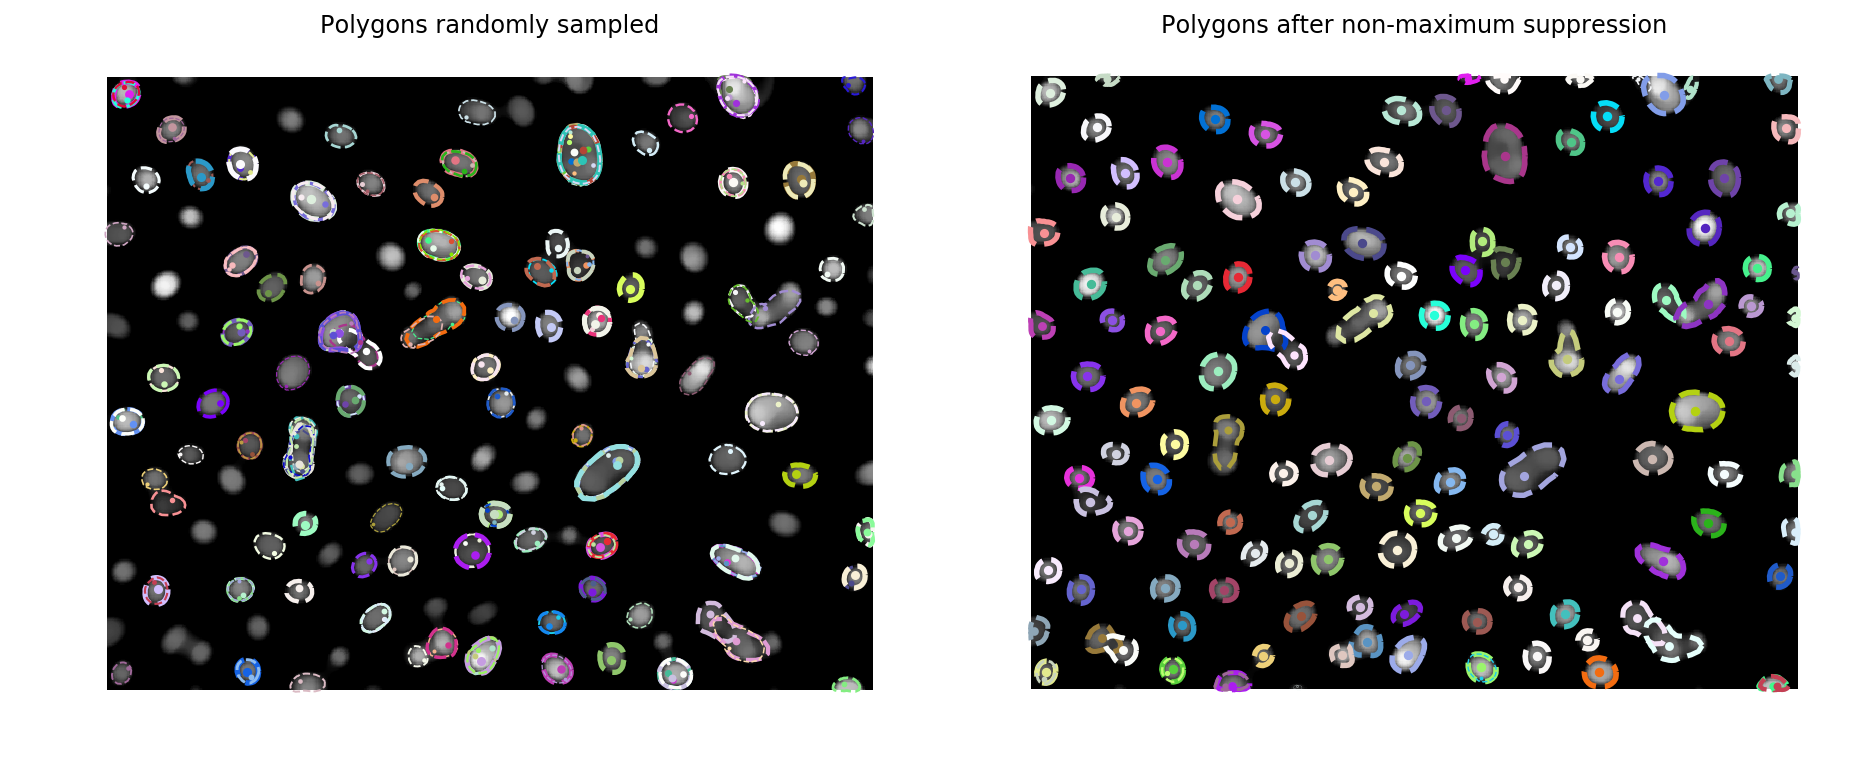

In [7]:
newsmalllabels = np.array(smalllabels)
newsmallprob = np.array(smallprob)
newsmalldist = np.array(smalldist)
newsmallimg = np.array(smallimg)
newsmallcoord = np.array(smallcoord)
newsmallpoints = np.array(smallpoints, dtype = 'i')
for i in range(timerange):
      print('Time point = ' , i)
      newsmalldist  = dist[i,:,:,:]
      newsmalllabels = labels[i,:,:] 
      newsmallprob = prob[i,:,:] 
      newsmallimg = img[i,:,:]
      newsmallpoints = points[i,:,:] 
      newsmallcoord = coord[i,:,:,:,:]
    

None;

plt.figure(figsize=(13,12))
points_rnd = sample_points(200,newsmallprob>0.2)
numberA = 121
numberB = 122 
plt.subplot(numberA); plt.imshow(newsmallimg,cmap='gray'); 
draw_polygons(newsmallcoord,newsmallprob,points_rnd,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons randomly sampled')
      
plt.subplot(numberB); plt.imshow(newsmallimg,cmap='gray'); draw_polygons(newsmallcoord,newsmallprob,newsmallpoints,cmap=lbl_cmap)
plt.axis('off'); plt.title('Polygons after non-maximum suppression')
plt.tight_layout()

In [23]:
def ApplyModelWithoutShape(model,i):
   
    for j in range(timerange):
      print('Time point = ' , j, 'Image number = ', i)
      smallimg = img[j,:,:]
      smallprob, smalldist = model_no_sc.predict(smallimg)
      smallcoord = dist_to_coord(smalldist)
      smallpoints = non_maximum_suppression(smallcoord,smallprob,prob_thresh=0.2)

      newsmallpoints[:smallpoints.shape[0], :smallpoints.shape[1]] = smallpoints;
   
      smalllabels = polygons_to_label(smallcoord,smallprob,newsmallpoints)
  
      prob[j,:,:] = smallprob[:,:] 
      labels[j,:,:] = smalllabels[:,:]
      dist[j,:,:,:] = smalldist[:,:,:]
      coord[j,:,:,:,:] = smallcoord[:,:,:,:]
    
    
    
        
        
    SegmentedLabelsWithoutShape.append(labels)
    print(len(SegmentedLabelsWithoutShape))
    plt.figure(figsize=(13,10))
    plt.subplot(121); plt.imshow(smallimg,cmap='gray'); plt.axis('off')
    draw_polygons(smallcoord,smallprob,smallpoints,show_dist=True)

Time point =  0 Image number =  0


/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/data/prepare.py:284: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return x[crop]


Time point =  1 Image number =  0
Time point =  2 Image number =  0
1
Time point =  0 Image number =  1
Time point =  1 Image number =  1
Time point =  2 Image number =  1
2


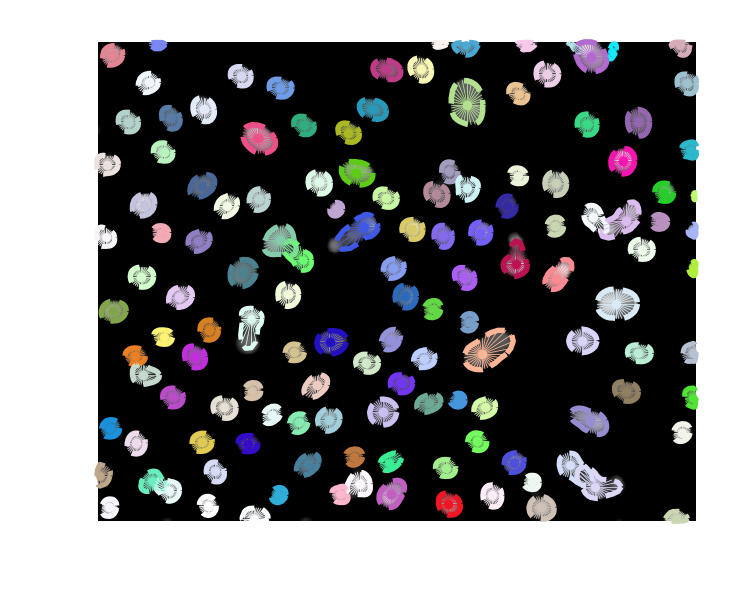

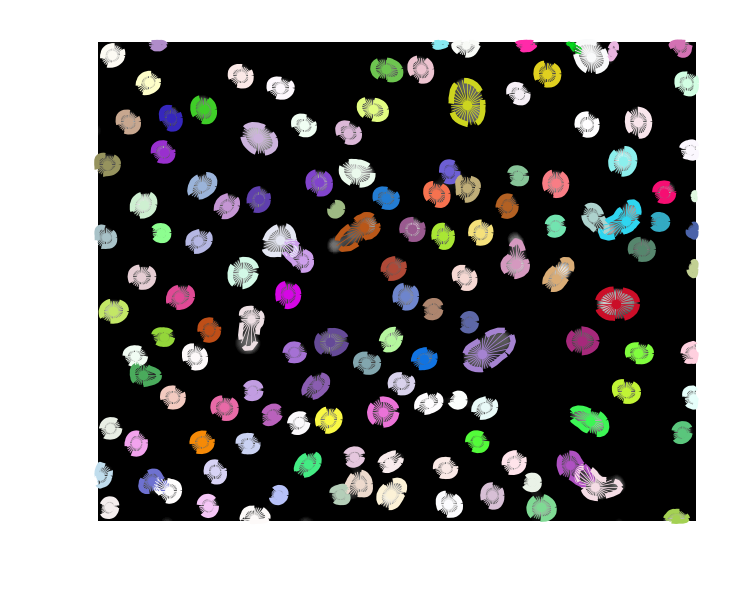

In [24]:
 SegmentedLabelsWithoutShape.clear()
for i in range(0, len(X)):
    
       ApplyModelWithoutShape(model_no_sc,i)

In [26]:
(basedirResultsWithoutShape)
for i in range(0, len(SegmentedLabelsWithoutShape)):
           print('Saving file'  + basedirResultsWithoutShape  + os.path.basename(Names[i]))
           save_tiff_imagej_compatible((basedirResultsWithoutShape + os.path.basename(Names[i])) , SegmentedLabelsWithoutShape[i], axes)   
           print(SegmentedLabelsWithoutShape[i].shape,len(SegmentedLabelsWithoutShape) )  
    
    

Saving file/data/u934/service_imagerie/v_kapoor/StarDistData/JuliaResultsData/WithoutShapeCompletion/calibrated-P51.001 copy.tif
(3, 512, 640) 2
Saving file/data/u934/service_imagerie/v_kapoor/StarDistData/JuliaResultsData/WithoutShapeCompletion/calibrated-P51.001.tif
(3, 512, 640) 2


/data/u934/service_imagerie/v_kapoor/anaconda2/envs/tensorflowpy3pt5/lib/python3.5/site-packages/csbdeep/utils/utils.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[slices]


In [11]:
plt.figure(figsize = (16, 10))
smallimg = img[timerange - 1,:,:]
Lastimage= SegmentedLabelsWithoutShape[len(SegmentedLabelsWithoutShape) - 1]
smallSegmentedLabelsWithoutShape = Lastimage[timerange - 1,:,:]
plt.subplot(111); plt.imshow(smallimg, cmap = 'gray'); plt.axis('off'); plt.title('Raw Image')
plt.subplot(121); plt.imshow(smallSegmentedLabelsWithoutShape , cmap = 'gray'); plt.axis('off'); plt.title('Segmentation without Shape correction (last timepoint of last image)')


IndexError: list index out of range

<Figure size 1152x720 with 0 Axes>